In [1]:
"""
CS 484 Final Project

Alexander Wei, a6wei@uwaterloo.ca, 20836214
Kaiz Nanji, k4nanji@uwaterloo.ca 20873846

Project #5
Semi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,
design and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in
the training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should
demonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one
basic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep
features (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss
enforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function
formulated in Bridle & MacKay "Unsupervised Classifiers, Mutual Information and Phantom Targets", NIPS 1991. 
"""

'\nCS 484 Final Project\n\nAlexander Wei, a6wei@uwaterloo.ca, 20836214\nKaiz Nanji, k4nanji@uwaterloo.ca 20873846\n\nProject #5\nSemi-supervised image classification: assuming that only M out of N images in the traingin data have ground truth labels,\ndesign and implement a weakly supervsied training of classification network that can benefit from unlabeled examples in\nthe training dataset(e.g. MNIST or CIFAR-10, but you need to ignore labels on a subset of training examples).You should\ndemonstrate how the performance changes as M gets progressively smaller. While you can use any well-motivated ideas, one\nbasic approach could be to combine cross-entropy on labeled points with (unsupervised) K-means clustering loss over deep\nfeatures (e.g. in the last layer before the linear classifier). It is also advisable to use augmentation (a loss\nenforcing consistent labeling of augmented training examples). You can also explore Mutual Information loss function\nformulated in Bridle & MacKay 

In [2]:
from src.encoder import *
from src.k_means import *
from src.loader import *
from src.utils import *

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
set_seed()

transform = get_transform()

class ClassificationNetwork:
    def __init__(self, labeled_percent):
        self.labeled_percent = labeled_percent
        self.labeled_train_loader, self.unlabeled_train_loader, self.val_loader = self.get_loaders()

    def get_loaders(self):
        # Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
        # When batch size changes, the learning rate may also need to be adjusted. 
        # Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
        TRAIN_BATCH_SIZE = 100

        # If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
        # but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
        NUM_WORKERS = 0

        dataset_handler = LabeledUnlabeledMNIST(self.labeled_percent)
        labeled_train = dataset_handler.labeled_dataset
        unlabeled_train = dataset_handler.unlabeled_dataset
        mnist_test = dataset_handler.mnist_test

        self.VALIDATION_SIZE = len(mnist_test)

        labeled_train_loader = DataLoader(labeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        unlabeled_train_loader = DataLoader(unlabeled_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
        val_loader = DataLoader(mnist_test, batch_size=len(mnist_test), num_workers=NUM_WORKERS, shuffle=False)

        return labeled_train_loader, unlabeled_train_loader, val_loader

    def train(self, epochs = 1, train_with_all_labeled = False):
        if train_with_all_labeled:
            %run -i "run.py" encoder 1 -t -e "{epochs}"
        else:
            %run -i "run.py" encoder "{self.labeled_percent}" -t -e "{epochs}"

    def get_encodes_targets(self, loader, encoder_model):
        encodes = None
        targets = None

        with torch.no_grad():
            for batch_id, (data, target) in enumerate(loader):
                data = data.to(device)
                encoded = encoder_model.encode(data)

                if batch_id == 0:
                    encodes = encoded
                    targets = target
                else:
                    encodes = torch.cat((encodes, encoded))
                    targets = torch.cat((targets, target))
        
        return encodes, targets

    def run_kmeans(self):
        k_means = KMeansModel(tensor_dims=256)

        encoder_model = EncoderModel(device, None)
        encoder_model.load_state_dict(torch.load("./saves/encoder_model_{}.pth".format(str(self.labeled_percent)[2:])))
        encoder_model = encoder_model.to(device)

        encoder_model.train(False)

        labeled_encodes, labeled_targets = self.get_encodes_targets(self.labeled_train_loader, encoder_model)
        unlabeled_encodes, unlabeled_targets = self.get_encodes_targets(self.unlabeled_train_loader, encoder_model)

        k_means.fit(labeled_encodes, labeled_targets, unlabeled_encodes)
        
        val_data, val_labels = next(iter(self.val_loader))
        encoded_val_data = encoder_model.encode(val_data.to(device))

        predictions = k_means.predict(encoded_val_data)

        confusion_matrix = np.zeros((10, 10))
        for label, pred in zip(val_labels, predictions):
            confusion_matrix[label, pred] += 1

        accuracy = sum([confusion_matrix[i][i] for i in range(10)]) / self.VALIDATION_SIZE
        print(f"Accuracy: {accuracy * 100}%")

        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[i for i in range(10)])
        disp.plot()
        plt.title("K Means Classifier Confusion Matrix")
        plt.show()


# Important Notes For Readers

**Occcasionally training the autoencoder fails because the loss diverges. This doesn't happen often and just try running it again a few times.**

Calling `network.train()` calls the underlying `run.py` script. You may choose to directly execute `run.py` with your preferred arguments and run `network.train()` without saving the model. Additionally, the script will prompt the user for whether to save the model. In Visual Studio Code, a text box will appear at the top of the screen instead. If you do not see the text box, try invoking the script directly. When executing `run.py`, provide the input through the terminal window.

cuda
Loss at epoch 0: 0.33091145753860474
Loss at epoch 1: 0.2560620903968811
Loss at epoch 2: 0.22782114148139954
Loss at epoch 3: 0.2162703275680542
Loss at epoch 4: 0.20473934710025787
Loss at epoch 5: 0.20091059803962708
Loss at epoch 6: 0.19371020793914795
Loss at epoch 7: 0.19449259340763092
Loss at epoch 8: 0.18702203035354614
Loss at epoch 9: 0.18526966869831085
Loss at epoch 10: 0.18813349306583405
Loss at epoch 11: 0.18245390057563782
Loss at epoch 12: 0.18067218363285065
Loss at epoch 13: 0.1819620132446289
Loss at epoch 14: 0.17978964745998383
Completed training! Final loss: 0.17978964745998383
Running validation...


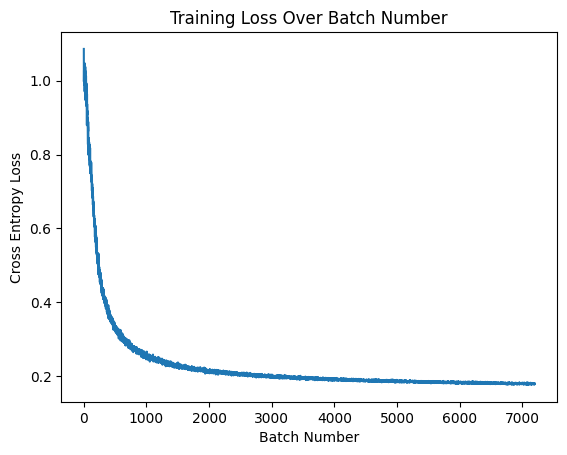

Saving model...
Accuracy: 59.98%


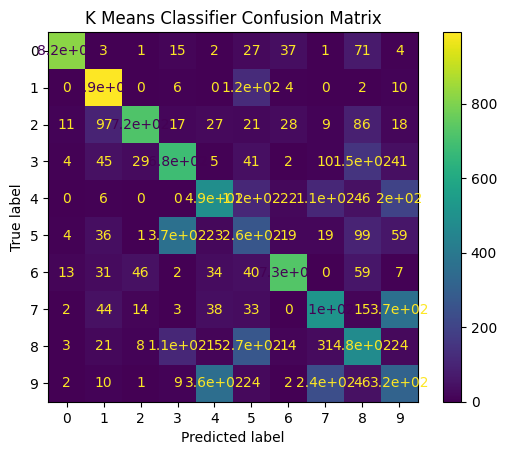

In [5]:
network = ClassificationNetwork(0.8)
network.train(epochs=15)
network.run_kmeans()

cuda
Loss at epoch 0: 0.42159831523895264
Loss at epoch 1: 0.30650103092193604
Loss at epoch 2: 0.26930445432662964
Loss at epoch 3: 0.24852947890758514
Loss at epoch 4: 0.22691136598587036
Loss at epoch 5: 0.22043336927890778
Loss at epoch 6: 0.21035896241664886
Loss at epoch 7: 0.20402202010154724
Loss at epoch 8: 0.2021605521440506
Loss at epoch 9: 0.20060840249061584
Loss at epoch 10: 0.1997266411781311
Loss at epoch 11: 0.19533437490463257
Loss at epoch 12: 0.19170932471752167
Loss at epoch 13: 0.18996092677116394
Loss at epoch 14: 0.19289632141590118
Completed training! Final loss: 0.19289632141590118
Running validation...


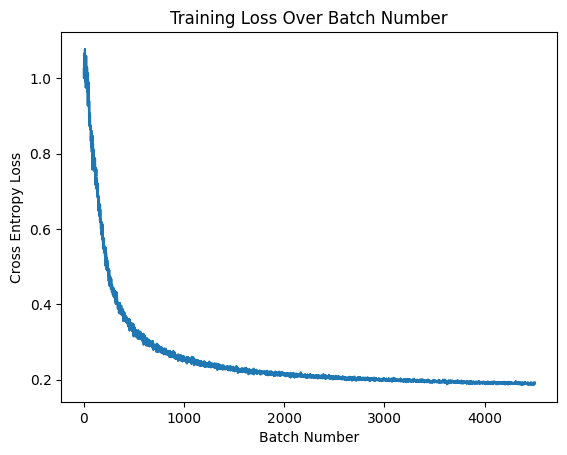

Saving model...
Accuracy: 53.5%


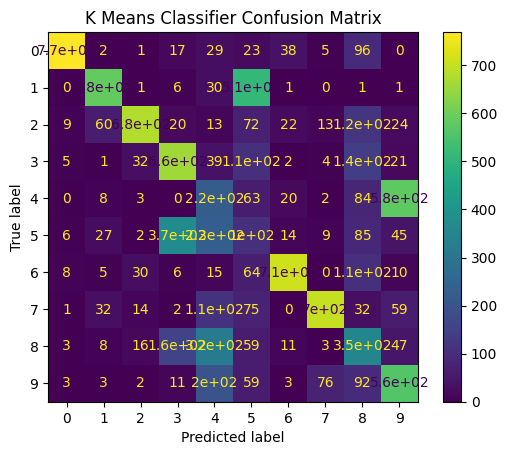

In [6]:
network = ClassificationNetwork(0.5)
network.train(epochs=15)
network.run_kmeans()

cuda
Loss at epoch 0: 0.7530671954154968
Loss at epoch 1: 0.48417922854423523
Loss at epoch 2: 0.3883611857891083
Loss at epoch 3: 0.3477868139743805
Loss at epoch 4: 0.3000766336917877
Loss at epoch 5: 0.28933629393577576
Loss at epoch 6: 0.2667415738105774
Loss at epoch 7: 0.256594181060791
Loss at epoch 8: 0.2509666085243225
Loss at epoch 9: 0.24210691452026367
Loss at epoch 10: 0.23342913389205933
Loss at epoch 11: 0.23142896592617035
Loss at epoch 12: 0.225728839635849
Loss at epoch 13: 0.22331027686595917
Loss at epoch 14: 0.21983568370342255
Loss at epoch 15: 0.2192114293575287
Loss at epoch 16: 0.21340824663639069
Loss at epoch 17: 0.20907363295555115
Loss at epoch 18: 0.20446403324604034
Loss at epoch 19: 0.20521394908428192
Completed training! Final loss: 0.20521394908428192
Running validation...


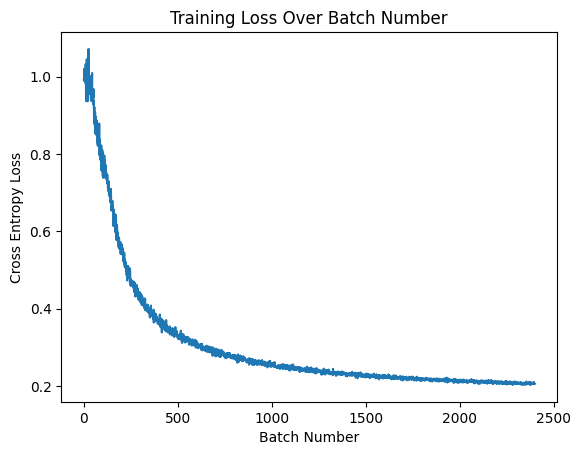

Saving model...
Accuracy: 55.67999999999999%


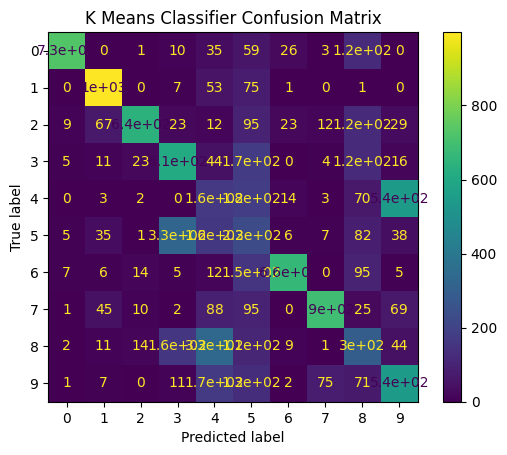

In [7]:
network = ClassificationNetwork(0.2)
network.train(epochs=20)
network.run_kmeans()

cuda
Loss at epoch 0: 1.0189646482467651
Loss at epoch 1: 1.0140256881713867
Loss at epoch 2: 0.9849298596382141
Loss at epoch 3: 0.9762744307518005
Loss at epoch 4: 1.0400704145431519
Loss at epoch 5: 0.9492043852806091
Loss at epoch 6: 0.9286838173866272
Loss at epoch 7: 0.9417235255241394
Loss at epoch 8: 0.9226093888282776
Loss at epoch 9: 0.8680927157402039
Loss at epoch 10: 0.8793146014213562
Loss at epoch 11: 0.8565666079521179
Loss at epoch 12: 0.8507202863693237
Loss at epoch 13: 0.7940434813499451
Loss at epoch 14: 0.8112183213233948
Loss at epoch 15: 0.7897891402244568
Loss at epoch 16: 0.7660057544708252
Loss at epoch 17: 0.7899115085601807
Loss at epoch 18: 0.7458482384681702
Loss at epoch 19: 0.7397868037223816
Loss at epoch 20: 0.7412845492362976
Loss at epoch 21: 0.6923472285270691
Loss at epoch 22: 0.7024216651916504
Loss at epoch 23: 0.660981297492981
Loss at epoch 24: 0.6281543970108032
Loss at epoch 25: 0.6440247297286987
Loss at epoch 26: 0.626072347164154
Loss at 

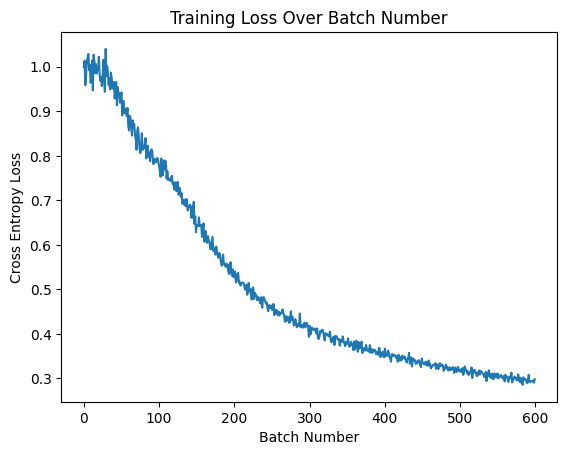

Saving model...
Accuracy: 52.61%


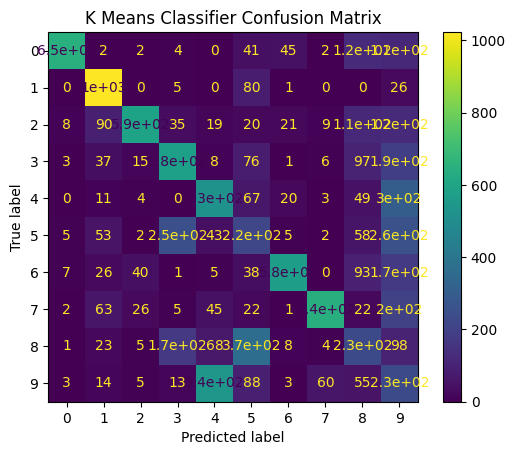

In [8]:
network = ClassificationNetwork(0.01)
network.train(epochs=100)
network.run_kmeans()

cuda
Loss at epoch 0: 0.3092639446258545
Loss at epoch 1: 0.24355114996433258
Loss at epoch 2: 0.2253483533859253
Loss at epoch 3: 0.21067193150520325
Loss at epoch 4: 0.2013758420944214
Loss at epoch 5: 0.19519703090190887
Loss at epoch 6: 0.19179058074951172
Loss at epoch 7: 0.18729203939437866
Loss at epoch 8: 0.18548555672168732
Loss at epoch 9: 0.1816447377204895
Completed training! Final loss: 0.1816447377204895
Running validation...


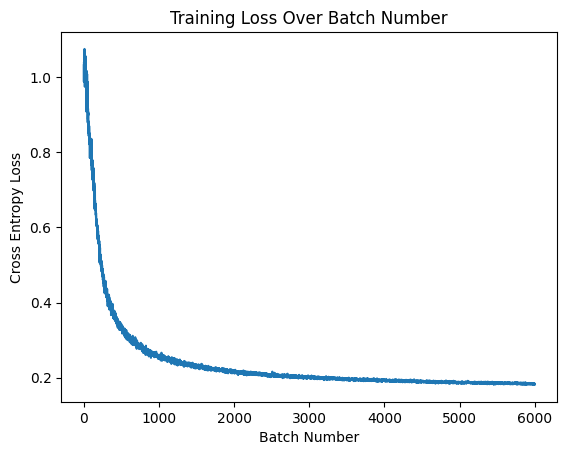

Saving model...
Accuracy: 55.67999999999999%


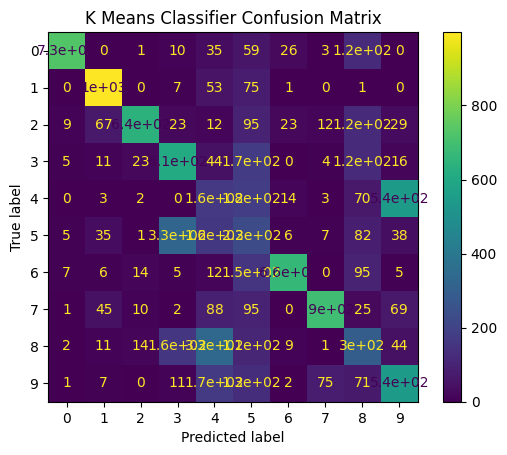

In [9]:
network = ClassificationNetwork(0.2)
network.train(epochs=10, train_with_all_labeled=True)
network.run_kmeans()